# Sentence Clustering With all-mpnet-base-v2

In [2]:
import random
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

ContextualVersionConflict: (numpy 1.21.4 (c:\users\hp\miniconda3\envs\nlp_env\lib\site-packages), Requirement.parse('numpy<1.21,>=1.17'), {'numba'})

## Load data and pre-trained models

In [2]:
data_sample = pd.read_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\data_sample.csv')
data_sample.head()

,Unnamed: 0,Processed_Title,cleaned_text
0,6372,"US coronavirus death toll rises to 14, most cases in Washington",u coronavirus death toll rise case washington
1,4678,"Iran rejects U.S. offer for coronavirus aid, cites conspiracy theory",iran reject u offer coronavirus aid cite conspiracy theory
2,4659,TSA is making 3 changes to stop coronavirus from spreading on planes,tsa making change stop coronavirus spreading plane
3,4611,NBA Players to Take Pay Cut Amidst Coronavirus Crisis,nba player take pay cut amidst coronavirus crisis
4,8314,"Coronavirus Cases confirmed in North Korea, say officials",coronavirus case confirmed north korea say official


In [3]:
all_title = list(data_sample['Processed_Title'])
len(all_title)

8376

In [4]:
all_title[:10]

['US coronavirus death toll rises to 14, most cases in Washington',
 'Iran rejects U.S. offer for coronavirus aid, cites conspiracy theory',
 'TSA is making 3 changes to stop coronavirus from spreading on planes',
 'NBA Players to Take Pay Cut Amidst Coronavirus Crisis',
 'Coronavirus Cases confirmed in North Korea, say officials',
 'Mayor Greg Fischer more coronavirus cases than thought',
 'Number Of Confirmed Coronavirus Cases In Southern Germany Rises To 4 Health Ministry',
 'Coronavirus live updates: US President Donald Trump declares coronavirus pandemic a national emergency',
 'South Africa Starts Easing Coronavirus Lockdown',
 'Coronavirus: Ekiti state government declares 14 day curfew']

In [5]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')

In [6]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences, show_progress_bar=True)
    
    return embeddings

In [7]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_title)

Batches:   0%|          | 0/262 [00:00<?, ?it/s]

In [8]:
embeddings = [embeddings_st1]

for embedding in embeddings:
    print(embedding.shape)

(8376, 768)


## Assitant Functions

In [9]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [10]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [11]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search parameter space of clustering pipeline

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               and 'min_cluster_size' and values with
               corresponding lists or ranges of parameters to search
        num_evals: int, number of random parameter combinations to try

    Returns:
        df_result: pandas dataframe containing info on each evaluation
                   performed, including run_id, parameters used, label
                   count, and cost
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors=n_neighbors, 
                                     n_components=n_components, 
                                     min_cluster_size=min_cluster_size, 
                                     random_state=random_state)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [12]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [13]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [14]:
def combine_results(df_ground, cluster_dict):
    """
    Returns dataframe of all documents and each model's assigned cluster

    Arguments:
        df_ground: dataframe of original documents with associated ground truth
                   labels
        cluster_dict: dict, keys as column name for specific model and value as
                      best clusters HDBSCAN object

    Returns:
        df_combined: dataframe of all documents with labels from
                     best clusters for each model

    """

    df_combined = df_ground.copy()
    
    for key, value in cluster_dict.items():
        df_combined[key] = value.labels_
    
    return df_combined

In [15]:
def summarize_results(results_dict, results_df):
    """
    Returns a table summarizing each model's performance compared to ground
    truth labels and the model's hyperparametes

    Arguments:
        results_dict: dict, key is the model name and value is a list of: 
                      model column name in combine_results output, best_params and best_clusters 
                      for each model (e.g. ['label_use', best_params_use, trials_use])
        results_df: dataframe output of combine_results function; dataframe of all documents 
                    with labels from best clusters for each model

    Returns:
        df_final: dataframe with each row including a model name, calculated ARI and NMI,
                  loss, label count, and hyperparameters of best model

    """
    
    summary = []

    for key, value in results_dict.items():
        
        predicted_label = results_df[value[0]].values
       
        loss = value[2].best_trial['result']['loss']
        label_count = value[2].best_trial['result']['label_count']
        n_neighbors = value[1]['n_neighbors']
        n_components = value[1]['n_components']
        min_cluster_size = value[1]['min_cluster_size']
        random_state = value[1]['random_state']
        
         
        summary.append([key, loss, label_count, n_neighbors, n_components, 
                        min_cluster_size, random_state])

   
    df_final = pd.DataFrame(summary, columns=['Model', 'loss', 'label_count', 'n_neighbors', 
                                              'n_components', 'min_cluster_size','random_state'])
    
    return df_final.sort_values(by='loss', ascending=False)

In [16]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

## Result with Default hyperparameters

In [106]:
clusters_default = generate_clusters(embeddings_st1, 
                                     n_neighbors = 20, 
                                     n_components = 10, 
                                     min_cluster_size = 30,
                                     random_state=42)

In [107]:
labels_def, cost_def = score_clusters(clusters_default)
print(labels_def)
print(cost_def)

55
0.3439589302769819


## Tuning hyperparameters

### Random hyperparameter search

In [82]:
%%time

space = {
        "n_neighbors": range(5,20),
        "n_components": range(3,10),
        "min_cluster_size": range(15,30),
        "random_state": 42
    }

random_use = random_search(embeddings_st1, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 19min 4s


In [86]:
random_use.head(100)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
47,47,9,4,18,94,0.255731
36,36,12,4,15,107,0.275907
64,64,7,8,17,95,0.275907
96,96,10,3,17,108,0.277221
24,24,13,9,17,87,0.277340
57,57,12,4,17,95,0.277579
59,59,8,7,28,59,0.278176
90,90,11,9,28,55,0.278295
72,72,17,7,15,103,0.278295
94,94,6,6,24,74,0.278534


### Bayesian optimization with Hyperopt

In [28]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(10,20)),
    "min_cluster_size": hp.choice('min_cluster_size', range(10,20)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [29]:
best_params_st1, best_clusters_st1, trials_st1 = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|█████████████████████████████████████████████| 100/100 [22:23<00:00, 13.43s/trial, best loss: 0.20403533906399235]
best:
{'min_cluster_size': 19, 'n_components': 10, 'n_neighbors': 6, 'random_state': 42}
label count: 87


### Clustering Performance

In [30]:
cluster_dict = {'label_st1': best_clusters_st1, }

results_df = combine_results(data_sample[['Processed_Title']], cluster_dict)
    
results_df.head()

,Processed_Title,label_st1
0,"US coronavirus death toll rises to 14, most cases in Washington",75
1,"Iran rejects U.S. offer for coronavirus aid, cites conspiracy theory",15
2,TSA is making 3 changes to stop coronavirus from spreading on planes,50
3,NBA Players to Take Pay Cut Amidst Coronavirus Crisis,60
4,"Coronavirus Cases confirmed in North Korea, say officials",29


In [31]:
model_dict = {'all-mpnet-base-v2': ['label_st1', best_params_st1, trials_st1]}

summarize_results(model_dict, results_df)

,Model,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
0,all-mpnet-base-v2,0.204035,87,6,10,19,42


## Viewing Clustering Results

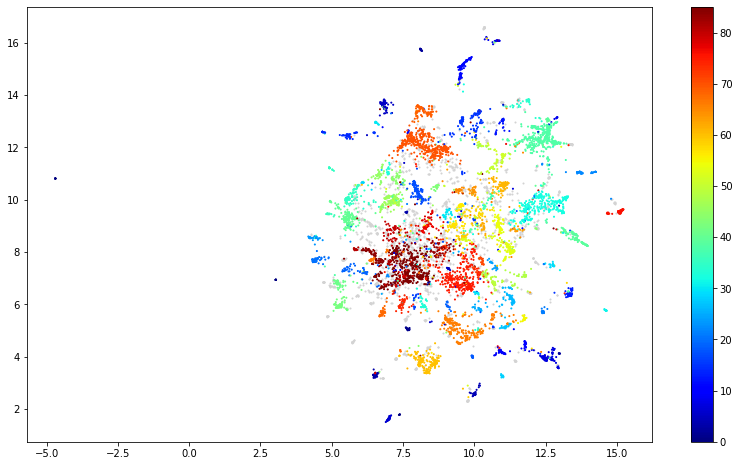

In [33]:
plot_clusters(embeddings_st1, best_clusters_st1)

In [32]:
results_df[results_df['label_st1']==44]

,Processed_Title,label_st1
321,2 Miami University students tested for coronavirus,44
462,"Starbucks employee diagnosed with the coronavirus in Seattle, company says",44
466,Stanford reports undergraduate student has coronavirus,44
702,"Secret Service employee has coronavirus, report says",44
860,Coronavirus: Second SABC employee tests positive for Covid 19,44
952,6 More Port Authority Employees Test Positive For Coronavirus,44
1106,Two Cubs' employees tested positive for coronavirus,44
1144,Coronavirus: Guelph Longo's employee tests positive for COVID 19,44
1145,Nestle factory worker tests positive for coronavirus,44
1407,Microsoft says two employees have been diagnosed with coronavirus,44


## Save Clustered Title

In [34]:
results_df.to_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\sample_clustered87.csv')

In [3]:
title_labels = pd.read_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\labeled_clusters99.csv')
title_labels.head()

,Processed_Title,label_st1,label,category
0,"US coronavirus death toll rises to 14, most ca...",85,reports_case_coronavirus_death,rises_37_coronavirus_death
1,"Iran rejects U.S. offer for coronavirus aid, c...",17,recover_coronavirus_death,refuses_offer_coronavirus_conspiracy
2,TSA is making 3 changes to stop coronavirus fr...,-1,coronavirus_coronavirus_pandemic,expands_change_airport_coronavirus
3,NBA Players to Take Pay Cut Amidst Coronavirus...,64,coronavirus_coronavirus_player,preparing_cut_coronavirus_game
4,"Coronavirus Cases confirmed in North Korea, sa...",21,vote_kit_coronavirus_case,coronavirus_exercise_case_week


In [5]:
title_labels[title_labels['label']=='recover_coronavirus_death']

,Processed_Title,label_st1,label,category
1,"Iran rejects U.S. offer for coronavirus aid, c...",17,recover_coronavirus_death,refuses_offer_coronavirus_conspiracy
410,Iran's Supreme Leader refuses US help with cor...,17,recover_coronavirus_death,refuses_offer_coronavirus_conspiracy
453,Iranian president urges coronavirus caution du...,17,recover_coronavirus_death,urges_caution_president_coronavirus
679,Fears raised in Iran of 'fresh outbreak' of co...,17,recover_coronavirus_death,coronavirus_coronavirus_case
888,"Over 180,000 Coronavirus Patients Recover in Iran",17,recover_coronavirus_death,recover_patient_%
941,WHO commends Iran's priorities to contain coro...,17,recover_coronavirus_death,coronavirus_coronavirus_case
948,Netanyahu Seeks Tighter Coronavirus Restrictio...,17,recover_coronavirus_death,seeks_sanction_coronavirus_case
1040,Iran's death toll from the coronavirus reaches...,17,recover_coronavirus_death,reaches_official_death_coronavirus
1118,Here's What Ramadan Looks Like During The Coro...,17,recover_coronavirus_death,fasting_time_coronavirus
1223,Hungary suspends issuing visas to Iranians ove...,17,recover_coronavirus_death,coronavirus_coronavirus_case


In [42]:
coronavirus_sample = title_labels[title_labels['label']=='coronavirus_coronavirus_case']
coronavirus_sample.shape

(1048, 3)

In [43]:
coronavirus_sample.to_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\coronavirus_sample.csv')